# Initial Data Preparation

## Code Setup

First, let's download the necessary libraries.

In [173]:
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu
from ucimlrepo import fetch_ucirepo

!pip install ucimlrepo
!pip install icd9cms

# https://pypi.org/project/icd9cms/
import icd9cms

In [174]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# This will be used for plotting
def plot_odds_ratios(model, title='Odds Ratios', xlabel='Odds Ratio (OR)', ylabel='Variables', significance_level=0.05, figsize=(8, 6), name=None):
    """
    Plots odds ratios with confidence intervals from a fitted logistic regression model.
    Parameters:
    - model: Fitted statsmodels logistic regression model.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - significance_level: Threshold for statistical significance.
    - figsize: Size of the plot.
    """
    # Extract coefficients, confidence intervals, and p-values
    params = model.params
    conf = model.conf_int()
    conf.columns = ['CI_lower', 'CI_upper']
    p_values = model.pvalues

    # Calculate odds ratios and their confidence intervals
    odds_ratios = np.exp(params)
    conf_odds = np.exp(conf)

    # Create a DataFrame for plotting
    results = pd.DataFrame({
        'OR': odds_ratios,
        'CI_lower': conf_odds['CI_lower'],
        'CI_upper': conf_odds['CI_upper'],
        'p_value': p_values
    })

    # Remove the intercept
    if 'const' in results.index:
        results = results.drop('const')

    # Determine significance
    results['Significant'] = results['p_value'] < significance_level

    # Plotting
    plt.figure(figsize=figsize)
    plt.grid(False)
    # Plot each variable
    for idx, row in results.iterrows():
        plt.errorbar(row['OR'], idx,
                     xerr=[[row['OR'] - row['CI_lower']], [row['CI_upper'] - row['OR']]],
                     fmt='o',
                     color='blue' if row['Significant'] else 'grey',
                     ecolor='grey',
                     elinewidth=2,
                     capsize=8)

    # Add a vertical line at OR = 1
    plt.axvline(x=1, color='red', linestyle='--')

    # Set y-ticks to variable names
    plt.yticks(range(len(results)), results.index)
    plt.ylim(-0.5, len(results) - 0.5)  # Add some padding around the top and bottom

    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Create custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Significant (p < {significance_level})',
               markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label=f'Not Significant (p ≥ {significance_level})',
               markerfacecolor='grey', markersize=8)
    ]
    plt.legend(handles=legend_elements, loc='best')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## Load Data Set

In [175]:
# Fetch dataset.
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# Import and initialize data set
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

raw_df = pd.concat([X, y], axis=1)

C:\Users\krpou\anaconda3\envs\pycharm_env\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## Create Dataset

In [176]:
# Copies original data set.
clean_df = raw_df.copy()

1. Remove the Variables with > 90% missing values

In [177]:
missing_var_percentage = (raw_df.isna().sum() / raw_df.shape[0])
missing_var_percentage[missing_var_percentage > 0.9].sort_values(ascending=False)

weight           0.968585
max_glu_serum    0.947468
dtype: float64

In [178]:
# Remove these columns
clean_df.drop(["weight", "max_glu_serum"], axis=1, inplace=True, errors="ignore")

# Check to see if they are still there
missing_var_percentage = (clean_df.isna().sum() / clean_df.shape[0])
missing_var_percentage[missing_var_percentage > 0.9].sort_values(ascending=False)

Series([], dtype: float64)

2. Remove the variables that have a high purity (>0.9995)

In [179]:
def check_purity_reached(df, max_purity):
    purity_dict = {}
    for col in df.columns:
        # Find the most frequent value's count and divide by the total number of rows
        most_frequent = df[col].value_counts(normalize=True).max()

        if most_frequent >= max_purity:
            purity_dict[col] = most_frequent
    return purity_dict

print(f"These are columns that are more pure than 99.95%:")
purity_dict = check_purity_reached(clean_df,  max_purity=0.9995)
purity_dict

These are columns that are more pure than 99.95%:


{'acetohexamide': 0.9999901735353655,
 'tolbutamide': 0.9997739913134053,
 'miglitol': 0.999626594343887,
 'troglitazone': 0.9999705206060964,
 'tolazamide': 0.9996167678792524,
 'examide': 1.0,
 'citoglipton': 1.0,
 'glipizide-metformin': 0.9998722559597508,
 'glimepiride-pioglitazone': 0.9999901735353655,
 'metformin-rosiglitazone': 0.9999803470707309,
 'metformin-pioglitazone': 0.9999901735353655}

In [180]:
# Drop these columns
column_names_to_remove = list(purity_dict.keys())
clean_df.drop(column_names_to_remove, axis=1, inplace=True, errors='ignore')

print(f"These are columns that are more pure than 99.95%:")
purity_dict = check_purity_reached(clean_df, max_purity=0.9995)
purity_dict

These are columns that are more pure than 99.95%:


{}

3. Remove the variables that are considered irrelevant

In [181]:
irrelevant_columns = ["payer_code", "medical_specialty", "encounter_id", "patient_nbr"]
clean_df.drop(irrelevant_columns, axis=1, inplace=True, errors='ignore')

4. Remove observations with no diagnoses (NA for diag_1, diag_2, or diag_3)

In [182]:
print(f"There are {sum(clean_df.isna().sum())} NA values.")

sum_of_na = clean_df.isna().sum()
sum_of_na[sum_of_na > 0]

There are 88823 NA values.


race          2273
diag_1          21
diag_2         358
diag_3        1423
A1Cresult    84748
dtype: int64

In [183]:
# remove the NA
clean_df.dropna(subset=['diag_1', 'diag_2', 'diag_3'], inplace=True)

# print the sum of the nas for those columns
print(clean_df[['diag_1', 'diag_2', 'diag_3']].isna().sum())

diag_1    0
diag_2    0
diag_3    0
dtype: int64


5. Impute remaining NAs with the median values

In [184]:
print(f"There are {sum(clean_df.isna().sum())} NA values.")

sum_of_na = clean_df.isna().sum()
sum_of_na[sum_of_na > 0]

There are 85836 NA values.


race          2191
A1Cresult    83645
dtype: int64

In [185]:
# Removes NA's from data.
numeric_cols = clean_df.select_dtypes(include=['number']).columns
categorical_cols = clean_df.select_dtypes(include=['object']).columns

clean_df[numeric_cols] = clean_df[numeric_cols].fillna(clean_df[numeric_cols].median())

for col in categorical_cols:
    clean_df[col].fillna(clean_df[col].mode()[0], inplace=True)

print(f"There are {sum(clean_df.isna().sum())} NA values.")

There are 0 NA values.


6. Remove the 'unknown' observations from gender

In [186]:
clean_df["gender"].value_counts()

gender
Female             53922
Male               46319
Unknown/Invalid        3
Name: count, dtype: int64

In [187]:
clean_df = clean_df[clean_df["gender"] != "Unknown/Invalid"]
clean_df["gender"].value_counts()

gender
Female    53922
Male      46319
Name: count, dtype: int64

In [188]:
clean_df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'insulin', 'glyburide-metformin', 'change', 'diabetesMed',
       'readmitted'],
      dtype='object')

# Sub Questions Tests

## Sub-question 1: Is there an association between race and 30-day hospital readmission rates, and is age a significant predictor of readmission?

#### Test 1: Chi-Square Test Between `age` and `readmitted`

In [189]:
pd.crosstab(clean_df['age'], clean_df['readmitted'] == '<30')

readmitted,False,True
age,,
[0-10),64,1
[10-20),438,31
[20-30),1298,217
[30-40),3206,410
[40-50),8456,1018
[50-60),15384,1660
[60-70),19796,2491
[70-80),22841,3055
[80-90),15030,2060


In [190]:
# Create a contingency table between age and 30-day readmission ('readmitted' == '<30')
contingency_table_age = pd.crosstab(clean_df['age'], clean_df['readmitted'] == '<30')

# Perform Chi-Squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_age)

# Print results
print(f"Chi-Squared Test for Age:")
print(f"Chi-squared statistic: {chi2_stat}")
print(f"p-value: {p_val}\n")

if p_val < 0.05:
    print("There is a significant association between age and 30-day readmission.")
else:
    print("There is no significant association between age and 30-day readmission.")

Chi-Squared Test for Age:
Chi-squared statistic: 91.18850112960793
p-value: 9.398980468091394e-16

There is a significant association between age and 30-day readmission.


#### Test 2: Chi-Square Test Between `race` and `readmitted`

In [191]:
pd.crosstab(clean_df['race'], clean_df['readmitted'] == '<30')

readmitted,False,True
race,,
AfricanAmerican,16741,2140
Asian,560,65
Caucasian,68572,8696
Hispanic,1777,207
Other,1341,142


In [192]:
# Create a contingency table between race and 30-day readmission ('readmitted' == '<30')
contingency_table_race = pd.crosstab(clean_df['race'], clean_df['readmitted'] == '<30')

# Perform Chi-Squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_race)

# print results
print(f"Chi-Squared Test for Race:")
print(f"Chi-squared statistic: {chi2_stat}")
print(f"p-value: {p_val}\n")

if p_val < 0.05:
    print("There is a significant association between race and 30-day readmission.")
else:
    print("There is no significant association between race and 30-day readmission.")

Chi-Squared Test for Race:
Chi-squared statistic: 6.0179941132941215
p-value: 0.19780848632032674

There is no significant association between race and 30-day readmission.


#### Test 3: Post-Hoc Analysis for Age and Race

In [193]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

## Create a logistical model to determine which age groups are at risk
# Define the binary outcome
y = (clean_df['readmitted'] == '<30').astype(int)

# Create dummy variables for 'race', dropping the first category to avoid multicollinearity
X = pd.get_dummies(clean_df['age'], drop_first=True)

# Convert bool X into integers
X = X.astype(int)

# Add an intercept to the model
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Print the summary of the model
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.350672
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:               100241
Model:                          Logit   Df Residuals:                   100231
Method:                           MLE   Df Model:                            9
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                0.001365
Time:                        17:39:28   Log-Likelihood:                -35152.
converged:                       True   LL-Null:                       -35200.
Covariance Type:            nonrobust   LLR p-value:                 9.818e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1589      1.008     -4.127      0.000      -6.134      -2.184
[10-20)        1.5107      1.

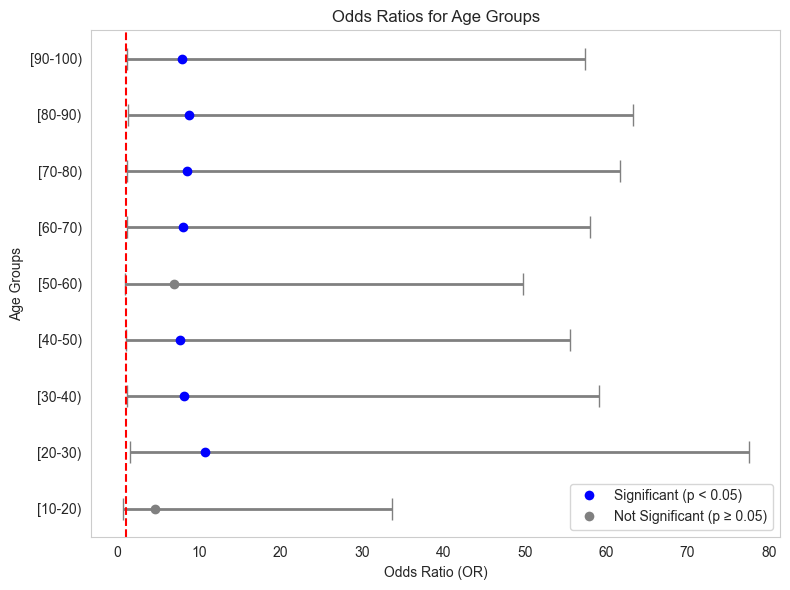

In [194]:
plot_odds_ratios(model, title='Odds Ratios for Age Groups', ylabel='Age Groups', significance_level=0.05, figsize=(8, 6), name='age_oddratio')

In [195]:
print("\nModel odds compared to reference group (0-9 year olds)")
print(np.exp(model.params))


Model odds compared to reference group (0-9 year olds)
const        0.015625
[10-20)      4.529680
[20-30)     10.699538
[30-40)      8.184654
[40-50)      7.704825
[50-60)      6.905876
[60-70)      8.053344
[70-80)      8.560046
[80-90)      8.771790
[90-100)     7.928975
dtype: float64


**Suprising Finding!**
The age group [20-30) is 10.7x more likely to be readmitted in less than 30 days compared to other age groups, compared to those that are 0-9 years old. This is followed by [80-90) with a 8.77x odds ratio compared to the reference group. That means that [20-30) is about 1.22x more likely compared to those that are [80-90)!

**Given that the data was collected from 1999 - 2008. Then those that are [20-30)
were born between 1969 (1999-30) and 1988 (2008-20). Did anything significant occur during this time?**

In [196]:
## Determine the threshold for groups that are at risk (let's find the group most at risk)

# What should the threshold be? # Try values like 8, 8.7, 8.7, and 10
# Notice that if you use 10, then there isn't enough data for the test below.
chosen_odds_threshold = 8.5

selected_age_groups = np.exp(model.params)[np.exp(model.params) > chosen_odds_threshold]

print("The following age groups are at an increased risk:")
print(selected_age_groups)

The following age groups are at an increased risk:
[20-30)    10.699538
[70-80)     8.560046
[80-90)     8.771790
dtype: float64


In [197]:
selected_age_groups.index

Index(['[20-30)', '[70-80)', '[80-90)'], dtype='object')

In [198]:
## Select only these ages from the race groups
# Get the index
age_indices = clean_df.loc[clean_df['age'].isin(selected_age_groups.index)].index

# Select those groups
selected_groups = clean_df.loc[age_indices, ["age", "race", "readmitted"]]
selected_groups

,age,race,readmitted
2,[20-30),AfricanAmerican,NO
7,[70-80),Caucasian,>30
8,[80-90),Caucasian,NO
13,[80-90),Caucasian,NO
18,[70-80),AfricanAmerican,>30
...,...,...,...
101761,[70-80),AfricanAmerican,>30
101762,[80-90),AfricanAmerican,NO
101763,[70-80),Caucasian,NO
101764,[80-90),Caucasian,NO


DOUBLE CHECK TO SEE IF THE ASSUMPTION THAT THERE ARE AT LEAST 5 OBSERVATIONS IS STILL TRUE.

In [199]:
# Select the age groups for race
contingency_table_race = pd.crosstab(selected_groups['race'], selected_groups['readmitted'] == '<30')

# Check for any cell with count less than 5
if (contingency_table_race < 5).any().any():
    print("\nError: Some cells have counts less than 5. The test results may not be reliable.")
else:
    print("\nAll cells have counts of 5 or more.")

contingency_table_race


All cells have counts of 5 or more.


readmitted,False,True
race,,
AfricanAmerican,5372,729
Asian,237,36
Caucasian,32601,4448
Hispanic,512,69
Other,447,50


In [200]:
## Perform one last chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_race)

if p_val < 0.05:
    print("There is a significant association between race and 30-day readmission. (for at risk groups)")
else:
    print("There is no significant association between race and 30-day readmission. (for at risk groups)")

print(f"\nChi-squared statistic: {chi2_stat}")
print(f"p-value: {p_val}\n")

There is no significant association between race and 30-day readmission. (for at risk groups)

Chi-squared statistic: 2.1482887105584894
p-value: 0.7085067834310648



### Results

We checked to see if there was a correlation between early readmission and race for age groups that are most at risk. It appears that there is no evidence to reject the hypothesis that are independent.

There is a correlation between age and readmission, but no correlation between race and readmission (even when looking at at-risk groups). However, it should be noted that for the most at risk [20-30), there isn't enough data to get a reliable result.

## Sub-question 2a: Does the distribution of time spent in the hospital differ between patients readmitted within 30 days and those not readmitted?

#### Mann-Whitney Test for Time Spent in Hospital and Readmission

In [201]:
"""
Mann-Whitney-U Test for Independence: this code performs a non-param test to check if
there is a significant difference in the average number of diagnoses between
patients who were readmitted within 30 days and those who were not readmitted at all.
"""
readmitted = clean_df[clean_df['readmitted'] == '<30']['time_in_hospital']
not_readmitted = clean_df[clean_df['readmitted'] == 'NO']['time_in_hospital']

stat, p = mannwhitneyu(readmitted, not_readmitted)

print(f"Mann-Whitney U Test for Time Spent in Hospital and Readmission:")
print(f"U statistic: {stat}")
print(f"p-value: {p}\n")

if p < 0.05:
    print("There is a significant difference in time spent in the hospital between the two groups.")
else:
    print("There is no significant difference in time spent in the hospital between the two groups.")

Mann-Whitney U Test for Time Spent in Hospital and Readmission:
U statistic: 336233332.0
p-value: 1.1535981059122244e-77

There is a significant difference in time spent in the hospital between the two groups.


## Sub-question 2b: Is there an association between the severity of the initial diagnosis and 30-day readmission rates?

#### Chi-Square Test Between `severity` and `readmitted`

In [202]:
"""
Create `Diagnoses` Table
"""

# this code is used to get the parent description
def get_top_parent(node):
    # check if already null
    if node is None:
        return None
    # iterate until the parent is reached
    while node and node.parent is not None:
        node = node.parent
    # return the description
    return node.short_desc

diagnoses = clean_df[["diag_1", "diag_2", "diag_3"]].copy()

# add the descriptions for the diagnoses
for column in ['diag_1', 'diag_2', 'diag_3']:
    diagnoses.loc[:, column + "_desc"] = diagnoses[column].apply(lambda code: get_top_parent(icd9cms.search(code)))

# Based on the ICD-9 code structure, A represents the general diagnostic category,
# while B is the more specific condition within that category for a code in the format AAA.BBB.
diagnoses.head()

,diag_1,diag_2,diag_3,diag_1_desc,diag_2_desc,diag_3_desc
1,276,250.01,255,"Endocrine, Nutritional And Metabolic Diseases,...","Endocrine, Nutritional And Metabolic Diseases,...","Endocrine, Nutritional And Metabolic Diseases,..."
2,648,250,V27,"Complications Of Pregnancy, Childbirth, And Th...","Endocrine, Nutritional And Metabolic Diseases,...",Supplementary Classification Of Factors Influe...
3,8,250.43,403,None,"Endocrine, Nutritional And Metabolic Diseases,...",Diseases Of The Circulatory System
4,197,157,250,Neoplasms,Neoplasms,"Endocrine, Nutritional And Metabolic Diseases,..."
5,414,411,250,Diseases Of The Circulatory System,Diseases Of The Circulatory System,"Endocrine, Nutritional And Metabolic Diseases,..."


In [203]:
# Merge `Diagnoses` Table with "readmitted" column in `clean_df` table
merged_df = diagnoses.merge(clean_df['readmitted'], left_index=True, right_index=True)[["diag_1", "diag_1_desc", "readmitted"]]
merged_df.head()

,diag_1,diag_1_desc,readmitted
1,276,"Endocrine, Nutritional And Metabolic Diseases,...",>30
2,648,"Complications Of Pregnancy, Childbirth, And Th...",NO
3,8,None,NO
4,197,Neoplasms,NO
5,414,Diseases Of The Circulatory System,>30


In [204]:
# Define severity levels for each diagnosis category
severity_mapping = {
    'Diseases Of The Circulatory System': 'High',
    'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders': 'Moderate',
    'Other': 'Low',
    'Diseases Of The Respiratory System': 'High',
    'Diseases Of The Digestive System': 'Moderate',
    'Injury And Poisoning': 'High',
    'Symptoms, Signs, And Ill-Defined Conditions': 'Low',
    'Diseases Of The Genitourinary System': 'Moderate',
    'Diseases Of The Musculoskeletal System And Connective Tissue': 'Low',
    'Mental Disorders': 'Moderate',
    'Diseases Of The Skin And Subcutaneous Tissue': 'Low'
}

merged_df['severity'] = merged_df['diag_1_desc'].map(severity_mapping)

# drop NaNs
merged_df.dropna(inplace=True)

severity_order = ['Low', 'Moderate', 'High']  # Adjust based on your actual severity levels
merged_df['severity'] = pd.Categorical(merged_df['severity'], categories=severity_order, ordered=True)

In [205]:
# Create a contingency table between severity and 30-day readmission ('readmitted' == '<30')
contingency_table_age = pd.crosstab(merged_df['severity'], merged_df['readmitted'] == '<30')

# Perform Chi-Squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_age)

# print results
print(f"Chi-Squared Test for Severity:")
print(f"Chi-squared statistic: {chi2_stat}")
print(f"p-value: {p_val}\n")

if p_val < 0.05:
    print("There is a significant association between severity and 30-day readmission.")
else:
    print("There is no significant association between severity and 30-day readmission.")

Chi-Squared Test for Severity:
Chi-squared statistic: 61.3312203172202
p-value: 4.809442357025884e-14

There is a significant association between severity and 30-day readmission.


In [206]:
## create a logistical model to determine which severities are associated
# Define the binary outcome
y = merged_df['readmitted'] == '<30'
y = y.astype(int)

# Ensure the severity is ordered correctly (optional, based on your data)
# Create dummy variables for 'severity', dropping the first category to avoid multicollinearity
X = pd.get_dummies(merged_df['severity'], drop_first=True)
X = X.astype(int)

In [207]:
print(X.describe())
print(y.value_counts())

           Moderate          High
count  89455.000000  89455.000000
mean       0.303750      0.529518
std        0.459879      0.499131
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      1.000000
75%        1.000000      1.000000
max        1.000000      1.000000
readmitted
0    79440
1    10015
Name: count, dtype: int64


In [208]:
# Add an intercept to the model
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Print the summary of the model
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.350229
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                89455
Model:                          Logit   Df Residuals:                    89452
Method:                           MLE   Df Model:                            2
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                0.001016
Time:                        17:39:32   Log-Likelihood:                -31330.
converged:                       True   LL-Null:                       -31362.
Covariance Type:            nonrobust   LLR p-value:                 1.448e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2681      0.028    -80.758      0.000      -2.323      -2.213
Moderate       0.2540      0.

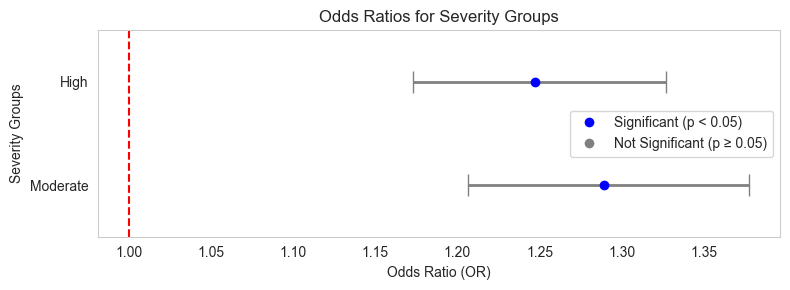

In [209]:
plot_odds_ratios(model, title='Odds Ratios for Severity Groups', ylabel='Severity Groups', significance_level=0.05, figsize=(8, 3), name='severity-odds')

In [210]:
print("\nModel odds compared to reference group (low severity)")
print(np.exp(model.params))


Model odds compared to reference group (low severity)
const       0.103507
Moderate    1.289206
High        1.247518
dtype: float64


#### Results

Compared to the low severity, diabetes patients with a moderate and high severity for their primary diganoses are 1.29x and 1.25x (respectively) more likely to be readmitted in less than 30 days.

## Sub-question 3: Do 30-day readmission rates differ between medication groups?

### Chi-Squared Test for Medication Groups and Readmission:

#### Approach 1: Considers 'steady', 'up', and 'down' as 1 and No as 0.

In [211]:
# Select medication columns (19 to 28) from clean_df
medications = clean_df.iloc[:, 18:29]

# include readmission
medications.loc[:, 'readmitted_less_30'] = clean_df['readmitted'].replace(['<30', '>30', 'NO'], ['1', '0', '0'])

# drop medications less than 350
medications = medications.drop(["chlorpropamide", "acarbose"] , axis=1)

# Replace categorical values: 'No' → 0, 'Down', 'Steady', 'Up' → 1
medications = medications.replace(['No', 'Down', 'Steady', 'Up'], [0, 1, 1, 1])

# Get top 10 most frequent primary diagnoses
top_diag = diagnoses['diag_1_desc'].value_counts().nlargest(10).index

# Merge medications with diagnoses on their index
medications = medications.merge(diagnoses[['diag_1_desc']], left_index=True, right_index=True)

# Filter to include only top diagnoses
medications = medications[medications['diag_1_desc'].isin(top_diag)]

# Transform DataFrame from wide to long format
medications = medications.melt(id_vars=['readmitted_less_30'], var_name='Medication', value_name='Value')

# Keep only medications that are used (Value == 1) and drop 'Value'
medications = medications[medications['Value'] == 1].drop('Value', axis=1)

# Reset index
medications = medications.reset_index(drop=True)

# Assign medication groups
def get_group(medication_name):
    medication_name = medication_name.lower()
    medication_groups = {
        'Sulfonylureas': ['chlorpropamide', 'glimepiride', 'glipizide', 'glyburide'],
        'Meglitinides': ['nateglinide', 'repaglinide'],
        'Thiazolidinediones': ['pioglitazone', 'rosiglitazone'],
        'Insulin': ['insulin'],
        'Alpha-glucosidase Inhibitors': ['acarbose'],
        'Metformin': ['metformin'],
    }
    for group, medications in medication_groups.items():
        if medication_name in medications:
            return group
    return 'unknown'

medications.loc[:, 'Group'] = medications['Medication'].apply(get_group)

medications

,readmitted_less_30,Medication,Group
0,0,metformin,Metformin
1,1,metformin,Metformin
2,0,metformin,Metformin
3,0,metformin,Metformin
4,0,metformin,Metformin
...,...,...,...
106004,0,insulin,Insulin
106005,0,insulin,Insulin
106006,0,insulin,Insulin
106007,0,insulin,Insulin


In [212]:
crosstable = pd.crosstab(medications['readmitted_less_30'], medications['Group'])
chi2, p, dof, expected = chi2_contingency(crosstable)

print(f"Chi-Squared Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

if p < 0.05:
    print("There is a significant association between readmission and medication group.")
else:
    print("There is no significant association between readmission and medication group.")

Chi-Squared Statistic: 94.48262321530039
P-Value: 1.4681761269754241e-19
Degrees of Freedom: 4
There is a significant association between readmission and medication group.


In [213]:
## Create a logistical model to determine which medication groups are associated
# Define the binary outcome
y = medications['readmitted_less_30']
y = y.astype(int)

# Ensure the medications is ordered correctly (optional, based on your data)
# Create dummy variables for 'medications', dropping the first category to avoid multicollinearity
X = pd.get_dummies(medications['Group']).drop('Metformin', axis=1)
X = X.astype(int)

# Add an intercept to the model
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Print the summary of the model
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.351377
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     readmitted_less_30   No. Observations:               106009
Model:                          Logit   Df Residuals:                   106004
Method:                           MLE   Df Model:                            4
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                0.001280
Time:                        17:39:34   Log-Likelihood:                -37249.
converged:                       True   LL-Null:                       -37297.
Covariance Type:            nonrobust   LLR p-value:                 8.894e-20
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2306      0.026    -87.418      0.000      -2.281      -2.181
Insul

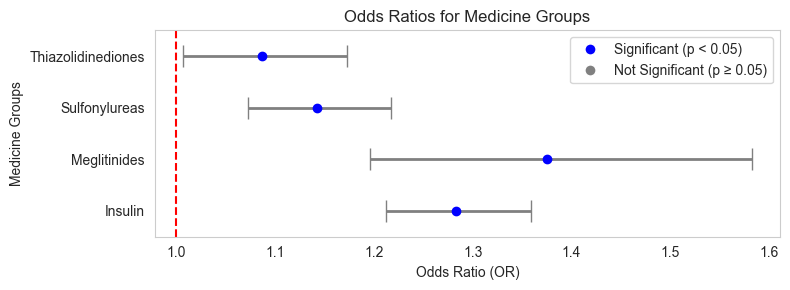

In [214]:
plot_odds_ratios(model, title='Odds Ratios for Medicine Groups', ylabel='Medicine Groups', significance_level=0.05, figsize=(8, 3))

In [215]:
print("\nModel odds compared to reference group (Metaformin)")
print(np.exp(model.params))


Model odds compared to reference group (Metaformin)
const                 0.107468
Insulin               1.283524
Meglitinides          1.375771
Sulfonylureas         1.142391
Thiazolidinediones    1.086611
dtype: float64


#### Approach 2: including all variables for medication

In [226]:
my_df = clean_df.copy()

# Features Selected Based on Statistical Results:
selected_features = ['age', 'time_in_hospital', 'severity', 'medication_group']

In [227]:
"""
This code adds the severity column to the dataframe.
"""
## Diagnosis Type
# this code is used to get the parent description
def get_top_parent(node):
    # check if already null
    if node is None:
        return None
    # iterate until the parent is reached
    while node and node.parent is not None:
        node = node.parent
    # return the description
    return node.short_desc

# add the descriptions for the diagnoses
for column in ['diag_1', 'diag_2', 'diag_3']:
    my_df.loc[:, column + "_desc"] = my_df[column].apply(lambda code: get_top_parent(icd9cms.search(code)))

## PRIMARY DIAG (DIAG_1) SEVERITY VARIABLE
# Define severity levels for each diagnosis category
severity_mapping = {
    'Diseases Of The Circulatory System': 'High',
    'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders': 'Moderate',
    'Other': 'Low',
    'Diseases Of The Respiratory System': 'High',
    'Diseases Of The Digestive System': 'Moderate',
    'Injury And Poisoning': 'High',
    'Symptoms, Signs, And Ill-Defined Conditions': 'Low',
    'Diseases Of The Genitourinary System': 'Moderate',
    'Diseases Of The Musculoskeletal System And Connective Tissue': 'Low',
    'Mental Disorders': 'Moderate',
    'Diseases Of The Skin And Subcutaneous Tissue': 'Low'
}

my_df['severity'] = my_df['diag_1_desc'].map(severity_mapping)

# drop NaNs
my_df.dropna(inplace=True)

severity_order = ['Low', 'Moderate', 'High']  # Adjust based on your actual severity levels
my_df['severity'] = pd.Categorical(my_df['severity'], categories=severity_order, ordered=True)

In [230]:
choices = [
    'Insulin and Metformin',
    'Insulin only',
    'Metformin only',
    'Sulfonylureas only',
    'Meglitinides only',
    'TZDs only',
    'Glyburide-metformin',
    'Other medications',
    'No medications'
]

medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                      'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
                      'rosiglitazone', 'acarbose', 'insulin', 'glyburide-metformin']

# Define medication groups
sulfonylureas = ['glipizide', 'glyburide', 'glimepiride']
meglitinides = ['repaglinide', 'nateglinide']
tzds = ['pioglitazone', 'rosiglitazone']
other_meds = ['chlorpropamide', 'acarbose']

# Create conditions for each medication group
conditions = [
    # Insulin and Metformin
    (my_df['insulin'] != 'No') & (my_df['metformin'] != 'No') &
    (my_df[[col for col in medication_columns if col not in ['insulin', 'metformin']]].eq('No').all(axis=1)),

    # Insulin only
    (my_df['insulin'] != 'No') & (my_df['metformin'] == 'No') &
    (my_df[[col for col in medication_columns if col != 'insulin']].eq('No').all(axis=1)),

    # Metformin only
    (my_df['metformin'] != 'No') & (my_df['insulin'] == 'No') &
    (my_df[[col for col in medication_columns if col != 'metformin']].eq('No').all(axis=1)),

    # Sulfonylureas only
    (my_df[sulfonylureas].apply(lambda x: (x != 'No').any(), axis=1)) &
    (my_df[[col for col in medication_columns if col not in sulfonylureas]].eq('No').all(axis=1)),

    # Meglitinides only
    (my_df[meglitinides].apply(lambda x: (x != 'No').any(), axis=1)) &
    (my_df[[col for col in medication_columns if col not in meglitinides]].eq('No').all(axis=1)),

    # TZDs only
    (my_df[tzds].apply(lambda x: (x != 'No').any(), axis=1)) &
    (my_df[[col for col in medication_columns if col not in tzds]].eq('No').all(axis=1)),

    # Glyburide-metformin combination only
    (my_df['glyburide-metformin'] != 'No') &
    (my_df[[col for col in medication_columns if col != 'glyburide-metformin']].eq('No').all(axis=1)),

    # Other medications only
    (my_df[other_meds].apply(lambda x: (x != 'No').any(), axis=1)) &
    (my_df[[col for col in medication_columns if col not in other_meds]].eq('No').all(axis=1)),

    # No medications
    (my_df[medication_columns].eq('No').all(axis=1)),
]

# Apply the conditions to create a new column 'medication_group'
my_df['medication_group'] = np.select(conditions, choices, default='Multiple Medications')

# Convert 'readmitted' column to binary
my_df['readmission_binary'] = my_df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [219]:
crosstable = pd.crosstab(my_df['medication_group'], my_df['readmitted'])

# Perform the chi-square test of independence
chi2, p, dof, expected = chi2_contingency(crosstable)

# print(crosstable,"\n")

# Print the results
print("Chi-Squared Statistic:", chi2)
print("P-Value:", p)
print("Degrees of Freedom:", dof)
print("\nExpected Frequencies Table:")
print(expected)

# Interpret the result
if p < 0.05:
    print("\nReject the null hypothesis: There is an association between medication group and readmission category.")
else:
    print("\nFail to reject the null hypothesis: There is no association between medication group and readmission category.")

Chi-Squared Statistic: 506.10519768323405
P-Value: 5.428910733129955e-96
Degrees of Freedom: 18

Expected Frequencies Table:
[[1.91470609e+01 6.11159507e+01 9.07369884e+01]
 [4.08582603e+02 1.30416435e+03 1.93625305e+03]
 [2.92334190e+03 9.33108328e+03 1.38535748e+04]
 [5.32982513e+01 1.70123933e+02 2.52577816e+02]
 [4.30193028e+02 1.37314317e+03 2.03866380e+03]
 [2.56794558e+03 8.19668546e+03 1.21693690e+04]
 [2.21478868e+03 7.06943570e+03 1.04957756e+04]
 [9.29360264e+00 2.96644673e+01 4.40419301e+01]
 [8.45605869e+02 2.69910912e+03 4.00728501e+03]
 [2.34803431e+02 7.49474554e+02 1.11272202e+03]]

Reject the null hypothesis: There is an association between medication group and readmission category.


In [233]:
X = pd.get_dummies(my_df['medication_group'], drop_first=True)
X = X.astype(int)  # Convert bools to int (1 or 0)

# drop the 'No Medications' column to set it as the reference category
X = X.drop('No medications', axis=1)

X = sm.add_constant(X)

y = my_df['readmission_binary']

if X.isnull().values.any() or y.isnull().values.any():
    print("NaN values found. Dropping NaN entries.")
    X = X.dropna()
    y = y.dropna()

try:
    model = sm.Logit(y, X)
    result = model.fit()

    print(result.summary())

    odds_ratios = pd.DataFrame({
        'OR': np.exp(result.params),
        '95% CI Lower': np.exp(result.conf_int()[0]),
        '95% CI Upper': np.exp(result.conf_int()[1])
    })

    print("\nOdds Ratios and 95% Confidence Intervals:")
    print(odds_ratios)

except ValueError as e:
    print("Error in fitting the model:", e)

Optimization terminated successfully.
         Current function value: 0.349650
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:     readmission_binary   No. Observations:                86692
Model:                          Logit   Df Residuals:                    86683
Method:                           MLE   Df Model:                            8
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                0.002757
Time:                        18:31:36   Log-Likelihood:                -30312.
converged:                       True   LL-Null:                       -30396.
Covariance Type:            nonrobust   LLR p-value:                 4.063e-32
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.2357      0.024    -93.284      0.000      -2.283      -2.

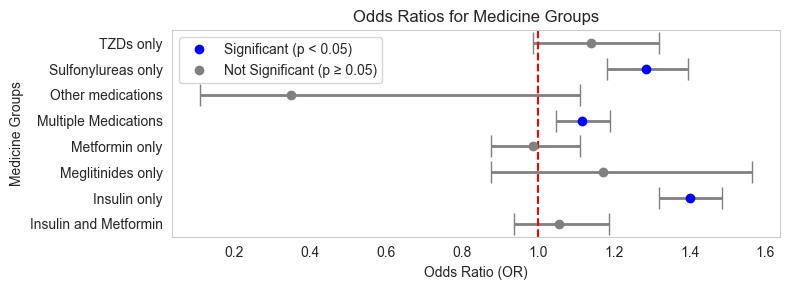

In [234]:
plot_odds_ratios(result, title='Odds Ratios for Medicine Groups', ylabel='Medicine Groups', significance_level=0.05, figsize=(8, 3), name="medicine_odds")